In [1]:
%matplotlib inline
# 权重衰退是为了缓解过拟合
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#通过公式生成一些数据
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5  # 20个样本的小样本集  维数d=200 使得过拟合的效果更加明显
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05# 标签被-均值为0 标准差为0.01 的高斯噪声破坏
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
# 初始化模型参数
def init_params():
    w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

In [4]:
# 定义L2范数惩罚  对所有项求平方后把它们求和
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [6]:
def train(lambd):# 超参数lambd
    w,b=init_params()
    net,loss=lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.003
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',
                          xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            """ 算损失       加上一个lambd项 约束w"""
            l=loss(net(X),y)+lambd*l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch+1)%5==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                                  d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是：',torch.norm(w).item())

w的L2范数是： 13.267491340637207


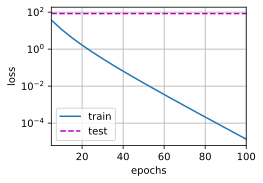

In [7]:
"""没有权重衰减直接训练"""
train(lambd=0)
"""训练误差减少，测试误差没有减少 说明出现了严重的过拟合"""
"""w范数很大 模型复杂度较大"""

w的L2范数是： 0.3604789078235626


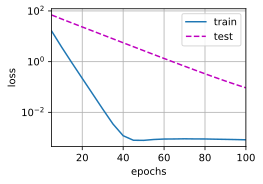

In [8]:
"""使用权重衰减"""
train(lambd=3)
"""w范数变小了 模型复杂度下降"""

w的L2范数是： 0.004653709474951029


'w范数变小了 模型复杂度下降'

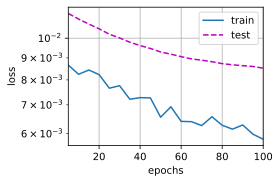

In [9]:
"""使用权重衰减"""
train(lambd=100)
"""w范数变小了 模型复杂度下降"""

In [10]:
"""简洁实现"""

def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},#罚可以写在目标函数里 也可以在训练算法里 每一次在更新权重前先给w乘以一个小的值
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 0.2924351692199707


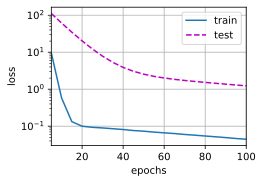

In [11]:
train_concise(5)